# Fictitious Degradation Dataset
For each experiment and for each loading condition there are different degradation paths that have some common
characteristics which we should discover.


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

In [2]:
from utils import get_indices, data_from_experiment, get_graph_data, get_graph_data_multiple_experiments, get_multi_batch

In [3]:
## imports that are related to the fictitious dataset:

from datasets.fictitious_dataset import lhs_sample,transform_exp_data_to_random_signal_params,add_disturbances_in_signal,get_dat, make_experiments_3conditions

In [4]:
latent = make_experiments_3conditions(nexp_per_case=10)
help(make_experiments_3conditions)

Help on function make_experiments_3conditions in module datasets.fictitious_dataset:

make_experiments_3conditions(nexp_per_case=1, base_rate=1.0, rates_shift=-0.5, base_concentration=3.0, concentration_shifts=0.2)
    This function creates the latent variable for all cases. 
    
    When the cummulative latent variable passes a threshold failure occurs.
    The returned experiments correspond to 3 damage evolution regimes.
    These parameters were hand-picked so that the evolution is aligned with 
    some assumptions on the evolution of damage, have sufficient 
    variation to make the problem non-trivial, and have sufficient 
    variation between the 3 evolution cases.  In future implementations it may be 
    interesting to combine evolution regimes for representing arbitrary loading.



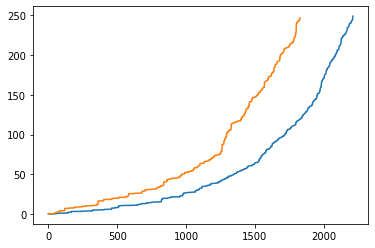

In [5]:
pplot.plot(latent[0]['latent_values'])
pplot.plot(latent[2]['latent_values'])


In [6]:
from datasets.fictitious_dataset import get_signal_for_segments

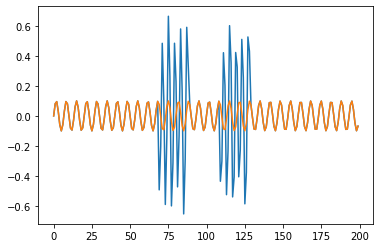

In [7]:
ss = get_signal_for_segments(latent[0]['latent_values'], speed = 150, rr=10)
pplot.plot(ss[-10,0:200])
pplot.plot(ss[10,0:200])


In [8]:
# for k in latent:
#     print(k)
#     pplot.plot(k['latent_values'])

In [9]:
latent = make_experiments_3conditions(nexp_per_case=10)


all_exp_dat = []
rr = 10
def reshape_ttf(v):
    if v.shape[0]%rr == 0:
        return np.mean(v.reshape([-1,rr]),1)
    else:
        return np.mean(v[:-(v.shape[0]%rr)].reshape([-1,rr]),1)
        
for d in latent:
    l = d['latent_values']
    ttf =d['ttf']
    
    y = reshape_ttf(ttf)
    case = d['case']
    speed_dict = {0:20, 1:25, 2:30}; # This is to superimpose a salient, yet irrelevant feature in the time-series.
                                     # Internally the network is expected to exploit this feature 
    if y.shape[0] == 0:
        break
    X = get_signal_for_segments(l, speed= speed_dict[case])
    eid = d['exp_index']

    exp_data = {
        "X" : X ,
        "eid" : (np.ones([X.shape[0],1]) * eid).astype(int),
        "y" : y,
        "case" : np.ones([X.shape[0],1]) * case
    }

    all_exp_dat.append(exp_data)

    

In [10]:
from datasets.fictitious_dataset import FictitiousDataset
        #self.inds_exp_source , self.inds_exp_target =         
        


In [11]:
fic=  FictitiousDataset(pct_val_set=0.3)


Created random data for fictitious experiment.
training experiments: 21 , testing 9


In [12]:
fic.X.shape,fic.y.shape, fic.cases.shape

((6404, 1000, 1), (6404, 1), (6404, 1))

In [13]:
def get_multi_batch_fictitious(*args, **kwargs):
    new_args = (args[0], fic)
    return get_multi_batch(*new_args, **kwargs)


In [14]:
d = get_multi_batch(4,fic, nseq_range=100, nnodes = 5, min_spacing=2)

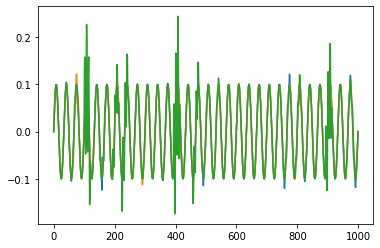

In [15]:
pplot.plot(exp_data['X'][0,:])
pplot.plot(exp_data['X'][10,:])
pplot.plot(exp_data['X'][100,:])


## Mini - graphnets
* **Edge**: Object keeping edge data - in this example dt and a latent output from the sender node.
* **Node**: Object keeping node data - in this example a latent variable (some function of observation and edge output).
* **Graph**: An object keeping edges/nodes corresponding to sequences of observations (and predictions?)
* **GraphNet**: An object defining how the computation happens on a graph object. It is a sequence of transformations and aggregations performed on edge and node states.

The information flowing through the graph may be better implemented in a sequential MC way. The nodes output samples or distributions, that are propagated by the edge to the time-instant corresponding to the receiver node. The edge aggregation function can be the application of Bayes rule in some way. 

## Utilities to make construction easier

## Classes for `Node` and `Edge` and `Graph`
These are classes encapsulating the attributes corresponding objects. Their behavior and the functions mutating them are implemented in a separate class (`GraphNet`) so that the graphNet can be evaluated with arbitrary graphs.

In [16]:
from minigraphnets import *

In [17]:
from graphnet_utils import GraphNetFunctionFactory
gn_tot = GraphNetFunctionFactory(channels_in =  1, 
                                 n_conv_blocks=2, 
                                 nfilts=32, 
                                 nfilts2=64,
                                 network_size_global = 100)

In [18]:
gn_tot.make_graphnet_comp_blocks(fic.X[0].shape[0])



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [19]:
n1 = Node(np.random.randn(3,1234,1))
n2 = Node(np.random.randn(3,1234,1))
e12 = Edge(np.random.randn(3,1,1) , n1,n2)
g = Graph([n1,n2],[e12])
v = gn_tot.eval_graphnets(g)

## The basic idea:
[alt-text](temporal_bayesian_graphnet.png)
Assuming this is markovian and I can capture something about the markov state with $z_i$, perhaps the second order links are not needed. Some more insight from what people in RL are using is needed to resolve this. 


### In more detail
* The input data, namely the raw time-series inputs and the difference in times for the observations,  are first transformed. The time-differences are simply projected to a 15 dimensional scalar and the time-series input is transformed using a convolutional neural network with global pooling to a 15 dimensional vector. 

* A second graph-net, that contains the causal links between the nodes of the graph, is then used to process the embedded quantities.
* The final inferred state is used to define the parameters of a `DistributionLambda` layer that is finally used to compute the final output. The final output is the time to failure for the final observation.

### Extensions
With adversarial learning the GraphNet should be able to infer prediction dependent and prediction independent states. This complicates implemetation (adversarial graph-nets would be yet another novel thing).

In [20]:
train_data = get_graph_data_multiple_experiments([0,2,3],fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
                                   nsamples_per_experiment = 50, nnodes = 5, min_spacing = 3, nseq_range=100)
gg_ = train_data[0][0]
predictions = train_data[0][1]

In [21]:
if False:
    gg_.edges[-1].edge_tensor.flatten().shape, predictions
    #gg_.edges[1].edge_tensor-gg_.edges[0].edge_tensor
    pplot.plot(gg_.edges[0].edge_tensor.flatten(),predictions.flatten(),'.')

## A cleaner training loop (with some standard training tricks)

In [22]:
from utils_train import EarlyStopping, LRScheduler, LossLogger
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(150,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 40, decay_rate = 0.99)

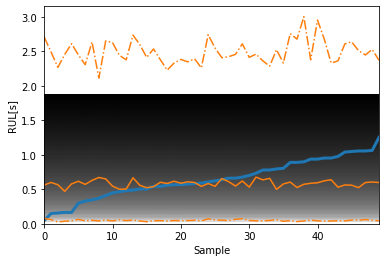

In [23]:
def eval_quantile(distr ,q, nsamples = 500):
    return np.quantile(distr.sample(nsamples),q,0)

def eval_graphnets(graph_in, iterations = 5):
    return gn_tot.eval_graphnets(graph_in.copy(), iterations = 5)

def plot_experiment_fit(graph_and_result_tuple, iterations =  5, colorscale_fn = lambda x : x, **kwargs):
    #ind_exp = 0;
    y = graph_and_result_tuple[1]
    t_probs= np.linspace(0,np.max(y)*1.5,102)
    distribution = eval_graphnets(graph_and_result_tuple[0])
    v = distribution.prob(t_probs).numpy().T    
    q1=eval_quantile(distribution,0.1)
    qm=eval_quantile(distribution,0.5)
    q2=eval_quantile(distribution,0.9)
    
    ids_sort = np.argsort(y.flatten());
    ysort = y[ids_sort.flatten()]
    xxvals = np.array([i for i in range(ysort.shape[0])])
    [xx,yy] = np.meshgrid(xxvals,t_probs)
    pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)
    pplot.plot(xxvals,y[ids_sort.flatten()],'C0-', linewidth = 3)
    pplot.plot(xxvals,q1[ids_sort],'C1-.')
    pplot.plot(xxvals,q2[ids_sort],'C1-.')
    pplot.plot(xxvals,qm[ids_sort],'C1-')
    
    pplot.xlabel("Sample")
    pplot.ylabel("RUL[s]")
    return v[:,ids_sort], q1,q2, distribution
    
yy,q1,q2,d  = plot_experiment_fit( train_data[0], colorscale_fn=lambda x : x ** 0.5,  cmap = "gray")
#pplot.plot(q1)


In [24]:
#gn_tot.eval_graphnets(train_data[0][0]).sample(1)

  0%|          | 0/200 [00:00<?, ?it/s]

nnodes: 1, seq_range 2 epoch: 0
loss: 20.278, val_loss 20.278
burn-in:  setting lr to 0.00000


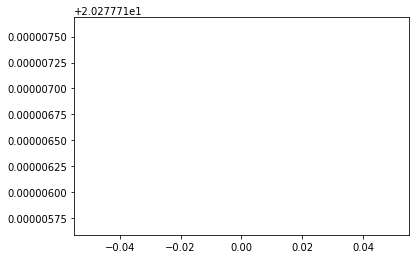

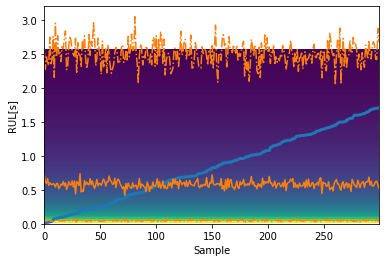

  0%|          | 1/200 [00:06<21:12,  6.39s/it]

nnodes: 2, seq_range 20 epoch: 1


  1%|          | 2/200 [00:16<24:39,  7.47s/it]

loss: 20.136, val_loss 20.136
burn-in:  setting lr to 0.00010
nnodes: 5, seq_range 50 epoch: 2


  2%|▏         | 3/200 [00:44<44:37, 13.59s/it]

loss: 17.785, val_loss 17.785
burn-in:  setting lr to 0.00020
nnodes: 10, seq_range 100 epoch: 3


  2%|▏         | 4/200 [01:26<1:12:55, 22.32s/it]

loss: 10.133, val_loss 10.133
burn-in:  setting lr to 0.00030
nnodes: 1, seq_range 2 epoch: 4


  2%|▎         | 5/200 [01:32<55:55, 17.21s/it]  

loss: 17.352, val_loss 17.352
burn-in:  setting lr to 0.00040
nnodes: 2, seq_range 20 epoch: 5


  3%|▎         | 6/200 [01:42<48:28, 14.99s/it]

loss: 12.513, val_loss 12.513
burn-in:  setting lr to 0.00050
nnodes: 5, seq_range 50 epoch: 6


In [ ]:
n_epochs = 200
nnodes_schedule = [1,2,5,10]
nseq_range_schedule = [2,20,50,100]
min_spacing_schedule = [1,5,5,5]
iterations_schedule = [5]
nbatch = 300
val_pct = 0.2 # percentage of sequence samples from the **seen ** experiments used as a validation set.
fixed_spacing_indices = False

eval_mode = "batched"
from tqdm import tqdm
for i in tqdm(range(n_epochs)):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    iterations = iterations_schedule[i%len(iterations_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    curr_data = get_multi_batch_fictitious(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in curr_data:
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            #print(graph_curr)
            #def eval_graphnets_loss(graph_curr_, ycurr_,iterations):
            prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations, eval_mode=eval_mode)
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
            #ycurr_t = y_curr[np.newaxis].T
            #ycurr_t = tf.Variable(ycurr_t)
            #loss_vals=  eval_graphnets_loss(graph_curr.copy(), ycurr_t, tf.constant(iterations))
            
            all_weights =gn_tot.weights() 
            
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        plot_experiment_fit(curr_data[0])
        pplot.show()

In [ ]:
#plot_experiment_fit()
#curr_data[2]

In [ ]:
#graph_indep.graph_eval(graph_data_.copy())
#graph_data_.nodes[0].node_attr_tensor.shape

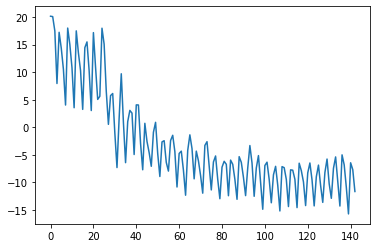

In [221]:
pplot.plot(loss_log.loss_history['val_loss'])
pplot.show()

In [222]:
help(get_graph_data_multiple_experiments)


    

Help on function get_graph_data_multiple_experiments in module utils:

get_graph_data_multiple_experiments(experiments, X_=None, eid_oh_=None, yrem_norm_=None, nsamples_per_experiment=None, nnodes=None, min_spacing=None, nseq_range=None, fixed_spacing_indices=False)



In [223]:
len(test_data)

9

<Figure size 1440x720 with 0 Axes>

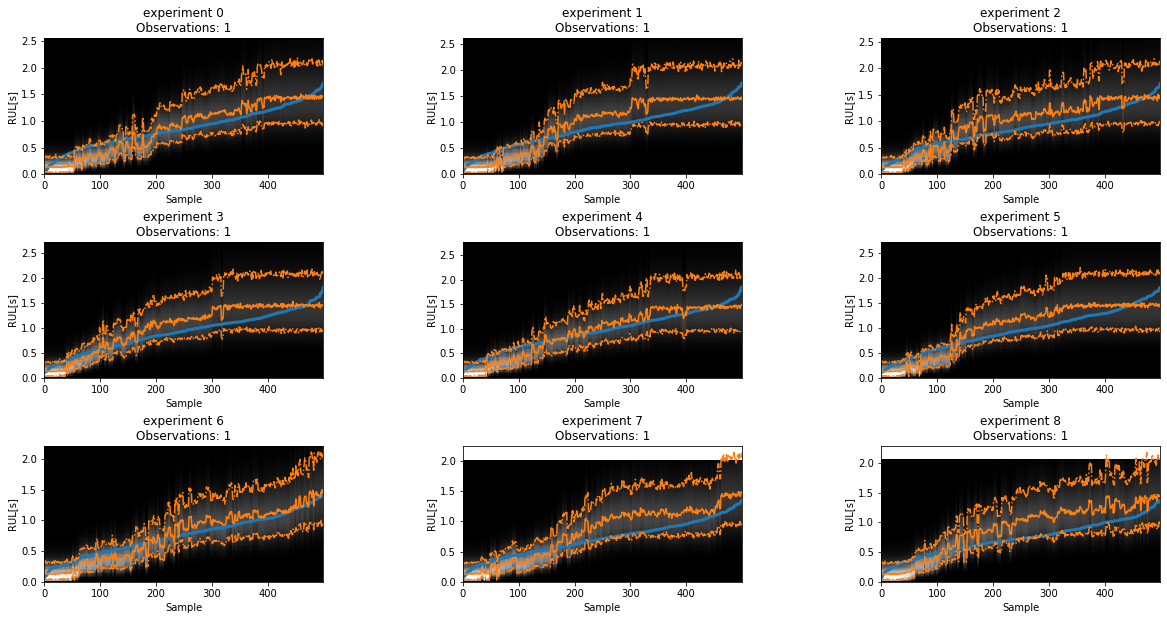

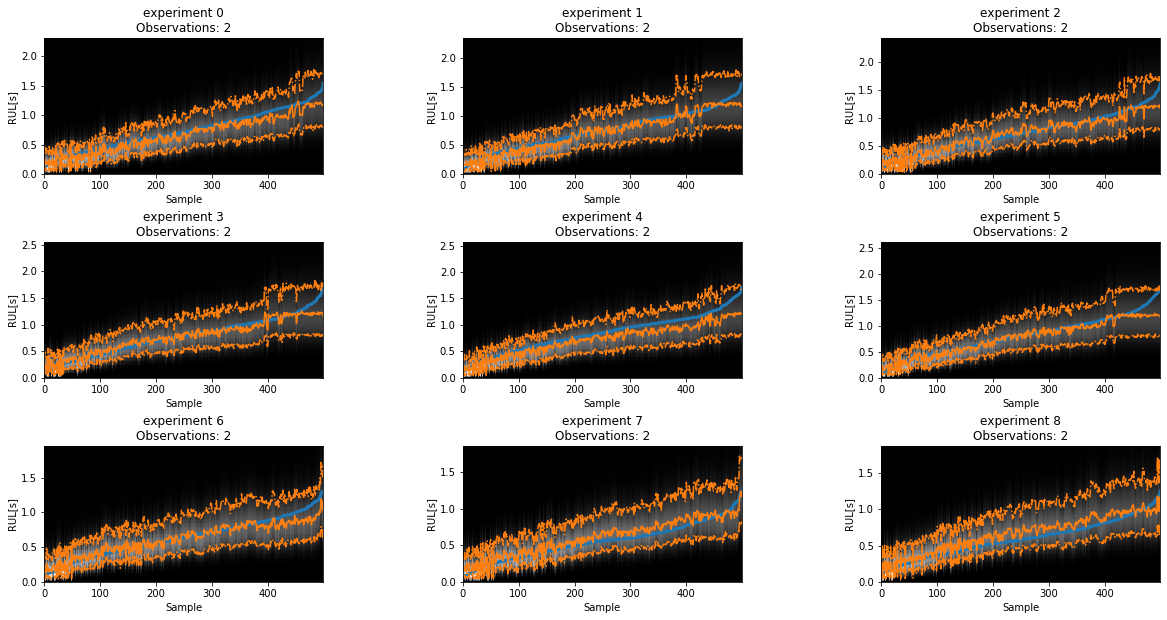

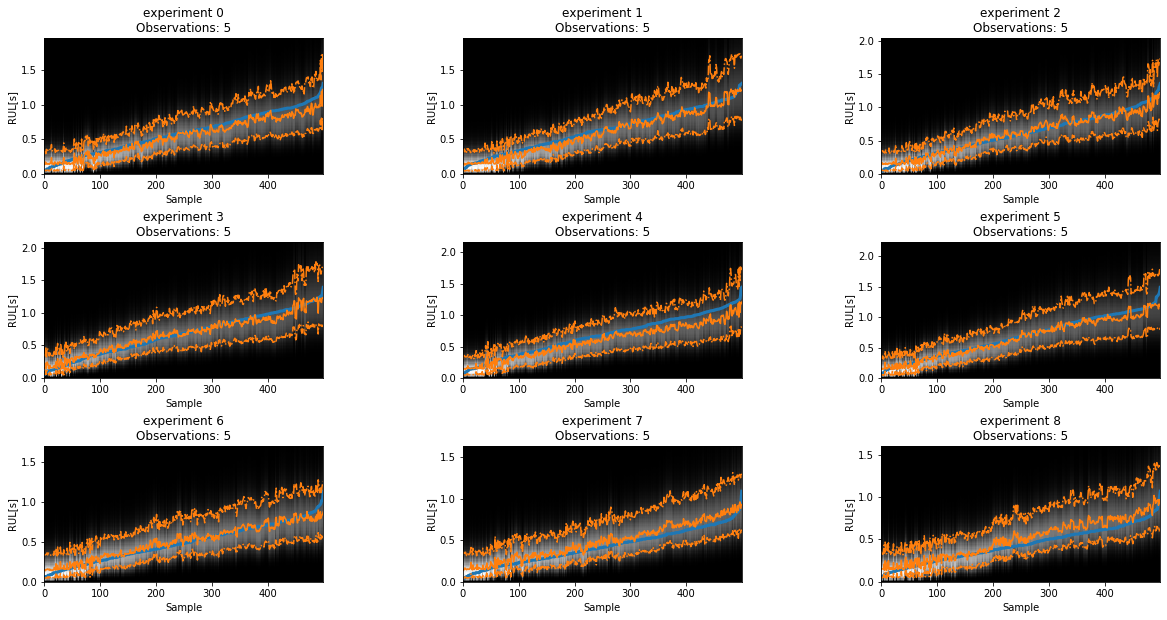

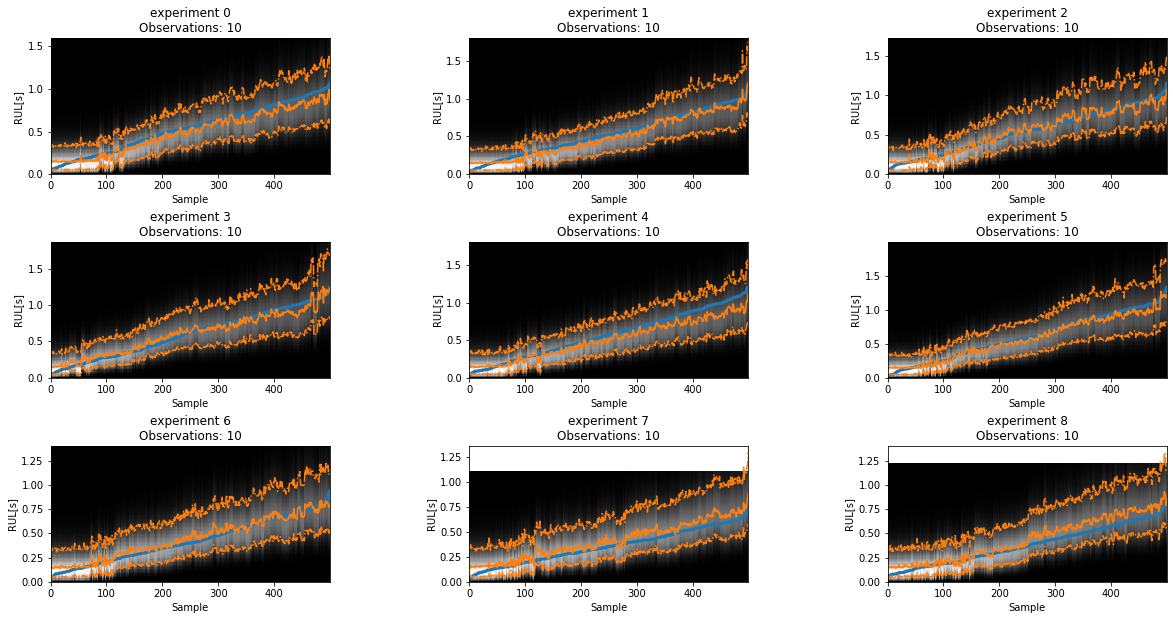

In [227]:
from IPython.display import clear_output
min_spacing = 5;
nseq_range = 100
pplot.figure(figsize = (20,10));
for nnodes in [1,2,5,10]:
#nnodes = 2

    pplot.figure(figsize = (20,10));

    test_data = get_graph_data_multiple_experiments(fic.inds_exp_target,fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
                                           nsamples_per_experiment = 500, nnodes = nnodes, min_spacing = min_spacing, nseq_range=nseq_range)

    for idx_experiment,data in enumerate(test_data):
        pplot.subplot(3,3,idx_experiment +1, title = "experiment {}\nObservations: {}".format(idx_experiment, nnodes))
        plot_experiment_fit(data, iterations=5, colorscale_fn = lambda x : x, cmap = "gray")
    pplot.subplots_adjust(wspace=0.5, hspace = 0.5)

In [96]:
# a whole experiment:
exp_idx = 2
d = get_dat(all_dat[exp_idx])
y = d['y']
X = d['X'][...,np.newaxis]
n = Node(X)
g = Graph([n],[])
vals = eval_graphnets(g.copy())

## Graph with two observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())


## Graph with three observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())

TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'

-0.9023638633306188

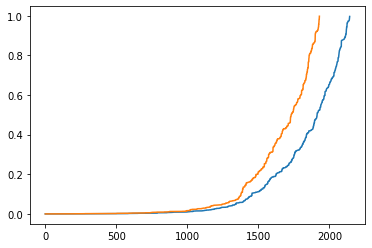

In [255]:
pplot.plot(((latent[0]['latent_values'])/250)**2)
pplot.plot(((latent[2]['latent_values']/250))**2)
np.random.randn()


In [485]:
#graph_indep.graph_eval(g2.copy())
#graph_data_val[0].edges[0].edge_tensor.shape#e01.edge_tensor.shape


In [486]:

X0.shape,X1.shape

((208, 1000, 1), (208, 1000, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'prob'

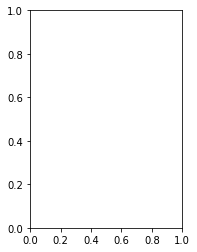

In [38]:
pplot.subplot(1,2,1)
#predictions_val[ids_sort.flatten()]
v = vals.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
# pplot.yscale("log")
# pplot.semilogy(y,"C1")
pplot.plot(y, "C1")

pplot.subplot(1,2,2)
v = vals2.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
#pplot.yscale("log")
#pplot.semilogy(y2_1,"C1")
pplot.plot(y2_1,"C1")


# Done. Success.